## Imports/etc

In [1]:
## Import required packages, global parameters

%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
# import xesmf as xe
%matplotlib inline
import momlevel
import datetime as dt
import xeofs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
panellabs=list(map(chr, range(97, 112)))
# panellabs

In [2]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [3]:
def detrend_df(df):

    df_det=df.copy()
    days = pd.to_datetime(df.index).map(dt.datetime.toordinal)
    trend=[]
    
    for column in df:
        y=df[column]
        not_nan_ind = ~np.isnan(y)
        coefficients = np.polyfit(days[not_nan_ind],y[not_nan_ind],1)    
        fit=np.polyval(coefficients,days)
        df_det[column]=df[column]-fit
        trend.append(coefficients[0])
    return df_det, np.array(trend)*365.25*10

## tg processing 1993-2022

In [4]:
## reading in TGs from PSMSL csvs (processing script elsewhere), converting to pandas dataframes

df_ids = pd.read_csv('PSMSL_ids.csv')
df_ids=df_ids.T
df_ids.index.names = ["name"]
df_ids.rename(columns={0: 'lat', 1: 'lon', 2: 'name2', 3: 'coast'}, inplace = True)
df_ids['coast']=df_ids['coast'].str.zfill(3)
df_ids.coast=df_ids.coast.astype(float)
df_ids.lat=df_ids.lat.astype(float)
df_ids.lon=df_ids.lon.astype(float)
df_ids=df_ids.sort_values(['lat'],axis=0,ascending=[True])
df_ids.lon=(df_ids.lon+360) % 360

df = pd.read_csv('PSMSL_data.csv')
df.columns,df_ids.columns
df.rename(columns = {'0':'datetime'}, inplace = True)
df['datetime']=pd.to_datetime(df.datetime-719529,unit='D').round('s')
df_ts=df
df_ts.set_index('datetime', inplace=True)

#time bounds of analysis
# df_ts=df_ts.loc['1995-01-01':'2019-1-1'] 
df_ts=df_ts.loc['1993-01-01':'2023-1-1'] 
df_ts=(df_ts-df_ts.mean(axis=0))/10 #mm->cm

In [5]:
## lat/lon range filtering
w=260; e=293; s=22; n=45; 
w=278.4; e=295; s=22; n=45; 
w=260; e=295; s=22; n=45; 

mask1 = df_ids['lat'] < n
mask2 = df_ids['lat'] > s
mask3 = df_ids['lon'] > w
mask4 = df_ids['lon'] < e
# mask5 = (df_ids['coast']) < 900
mask=mask1*mask2*mask3*mask4#*mask5#*mask6 #small subset
df_ids=df_ids[mask]
df_ids=df_ids.reset_index()
df_ts = df_ts[df_ids.name]
len(df_ts.T) #number of tgs in region

129

In [6]:
# tgs_in1=tgs_in[tgs_in["coast"] > 941]
# tgs_in2=tgs_in[tgs_in["coast"] < 941]
# tgs_in2.sort_values(['lon'],axis=0,ascending=[False])
# tt=pd.concat([tgs_in2,tgs_in1])
# tt

In [7]:
missingmonths = df_ts.isna().sum()
fraccomplete = 1-(missingmonths/len(df_ts))
mask0=(df_ids.lat<35).values*(fraccomplete > .95).values #south of hatteras
mask1=(df_ids.lat>35).values*(fraccomplete > .98).values #north of hatteras
mask2=(mask0+mask1)>0
mask3=~df_ids.name.isin(['636','148','135','2323','2325','2324','1444','224','429']).values #upriver north of hatteras
# mask4=~df_ids.name.isin(['497','161','526','1193','520']).values #remove GoM

# mask1 = df_ts['1977-1-1':'1978-1-1'].isna().sum()<12 #data in first year
mask=mask2*mask3#*mask4
tg_ts_filt = df_ts.loc[:,mask]
tgs_in=df_ids
tgs_in.index=tgs_in.name
tgs_in=tgs_in[mask]
missingmonths=missingmonths[mask]

tgnames=tgs_in['name2'].str.replace(r"\(.*\)","").str.replace(r"\,.*","").str.replace(r"\-.*","").str.replace(r"\/.*","").str.title()
tgnames
shortname=tgnames.str.split('(').str[0]
shortname=shortname.str.split(',').str[0]
# shortname['t2']=shortname['t2'].values
shortname

name
188           Key West
1701          Vaca Key
1858      Virginia Key
497        Port Isabel
1107            Naples
520     St. Petersburg
538           Rockport
526         Grand Isle
161       Galveston Ii
1193      Apalachicola
1641       Panama City
246          Pensacola
395       Fort Pulaski
234       Charleston I
396         Wilmington
2295          Beaufort
299      Sewells Point
1295      Cambridge Ii
1153          Cape May
12           New York 
351            Newport
183         Portland  
Name: name2, dtype: object

In [8]:
# interpolate
maxgap=2
tg_demean=tg_ts_filt-tg_ts_filt.mean()
# tg_ibcorr_gmrem=tg_ibcorr-gmsl_df
tg_det,tg_trend = detrend_df(tg_demean)
tg_sea=tg_det.groupby(tg_det.index.month).transform(lambda x: x.mean())
tg_desea=tg_demean-tg_sea
tg_interp=tg_desea.interpolate(axis=0,limit=maxgap, limit_direction='both')
tg_interp=tg_interp+tg_sea

## IB-correct filtered TG's using ERA5 surface P

In [9]:
#load surface pressure dataset
datadir = '/glade/campaign/collections/rda/data/d633001/e5.moda.an.sfc/'
# d633000
years=np.arange(1993,2023,1)
datasets = []
for Y in years:
    # print(Y)
    pic = xr.open_mfdataset(datadir+(str(Y))+'/e5.moda.an.sfc.128_134_sp.ll025sc.'+(str(Y))+'*.nc')
    datasets.append(pic)
era5 = xr.concat(datasets, dim='time')
era5#.load()

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 360, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2022-12-01
Data variables:
    SP         (time, latitude, longitude) float32 1GB dask.array<chunksize=(3, 389, 776), meta=np.ndarray>
    utc_date   (time) int32 1kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:51:22 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:51:23 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

In [10]:
#extract closest pts to TGs
def extract_point(arr, row):
    """Function to extract point from an array
    This function takes an individual row from the output of
    util.geolocate_points and used the information to extract
    that location from the array.
    Parameters
    ----------
    arr : xarray.core.dataarray.DataArray
        Input data array
    row : pandas.core.series.Series
        Row from DataFrame of mapped locations. This row must
        include `name`, `dims`, and `dim_vals`
    Returns
    -------
    xarray.core.dataarray.DataArray
    """
    return xr.DataArray(
        arr.sel(**dict(zip(row["dims"], row["dim_vals"]))),
        name=row["name"],
        attrs={**arr.attrs, **dict(row)},
    ).reset_coords(drop=True)

_xcoord = era5.longitude
_ycoord = era5.latitude

if len(_xcoord.shape) == 1:
       _xcoord, _ycoord = momlevel.tidegauge.tile_nominal_coords(_xcoord, _ycoord)

#     # Check that dimensions are the same for x/y coords
_xdims = tuple(_xcoord.dims)
_ydims = tuple(_xcoord.dims)
assert _xdims == _ydims

    # Make sure mask does not have missing values
mask = xr.ones_like(_xcoord)
if mask.name != "mask":
    mask = mask.rename("mask")

    # Create pandas.DataFrame of model coordinate info
df_model = pd.concat(
    [
        _xcoord.to_dataframe(),
        _ycoord.to_dataframe(),
        mask.to_dataframe(),
    ],
    axis=1,
)

df_mapped = momlevel.tidegauge.geolocate_points(
    df_model, tgs_in, model_coords=(_ycoord.name, _xcoord.name) 
    )
df_mapped["dims"] = [_xdims] * len(df_mapped)

results = xr.Dataset(
        {row["name"]: extract_point(era5.SP, row) for index, row in df_mapped.iterrows()}
    )
results_df=results.to_dataframe()
results_df.columns = results_df.columns.astype(str)
results_df['time']=tg_interp.index
results_df.set_index('time', inplace=True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/momlevel/util.py:514: UserWarning: Constructing coordinates from 1-D vectors. Make sure this is the intended behavior. Do not use `xh`/`yh` when `geolon`/`geolat` are available
  warnings.warn(


In [11]:
#IB removal
tg_ib=-9.948*(results_df/100-1013.3)
tg_ib=(tg_ib-tg_ib.mean(axis=0))/10
tg_ibcorr=tg_interp-tg_ib

In [12]:
# #NO IB removal
# # tg_ib=-9.948*(results_df/100-1013.3)
# # tg_ib=(tg_ib-tg_ib.mean(axis=0))/10
# tg_ibcorr=tg_interp#-tg_ib

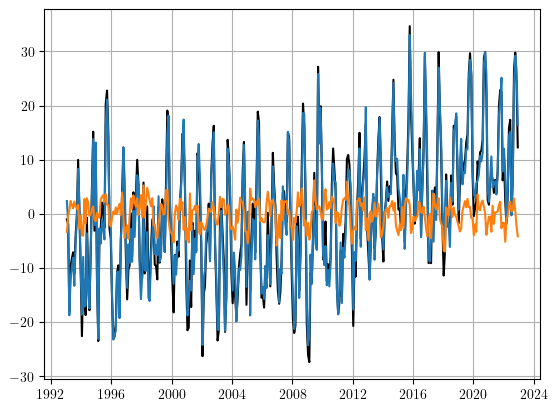

In [14]:
#double check
tgid='234'
plt.plot(tg_interp[tgid],'k')
plt.plot(tg_ibcorr[tgid])
plt.plot(tg_ib[tgid]) 
plt.grid()

In [15]:
vlmdf=pd.read_csv('../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/hammond_excerpt.csv')
vlmdf.index=vlmdf.ID.astype(str)
vlmdf=vlmdf.T[tgs_in.index].T
tgs_in['VLM']=vlmdf.VLM
tgs_in['VLM_sigma']=vlmdf.SIGMA
# tgs_in
vlm = (da_tg*0+(da_tg.time[0]-da_tg.time))*tgs_in.VLM.values/10

# da_tg_vlmrem=da_tg-vlm
vlmdf

,ID,VLM,SIGMA
ID,,,
188,188.0,-1.597,0.304
1701,1701.0,-1.497,0.254
1858,1858.0,-1.380,0.303
497,497.0,-2.035,0.233
1107,1107.0,-1.597,0.307
520,520.0,-1.141,0.364
538,538.0,-2.035,0.307
526,526.0,-7.116,0.302
161,161.0,-3.716,0.504


In [12]:
da_tg_vlmgmrem = da_tg_vlmrem-gmsl_merged.to_numpy() # if gm removal
da_tg_vlmrem = da_tg_vlmrem-da_tg_vlmrem.mean("time") # if no gm removal
da_tg_vlmgmrem = da_tg_vlmgmrem-da_tg_vlmgmrem.mean("time") # if no gm removal

## removal of global mean/detrend/deseason

In [14]:
gmsl = xr.open_dataset("gmsl_mo.nc")
gmsl_df=gmsl.to_pandas()/10
gmsl=gmsl_df['1993-01-01':'2023-01-01'].to_numpy()
# gmsl=gmsl_df['1995-01-01':'2019-01-01'].to_numpy()

In [15]:
tg_ibcorr_gmrem=tg_ibcorr-gmsl
tg_ibcorr_gmrem=tg_ibcorr_gmrem-tg_ibcorr_gmrem.mean()
tg_ibcorr_det,tg_ibcorr_trend = detrend_df(tg_ibcorr_gmrem)
# tg_ibcorr_det = (tg_ibcorr_gmrem)
tg_ibcorr_desea=tg_ibcorr_det.groupby(tg_ibcorr_det.index.month).transform(lambda x: x-x.mean())
tg_ibcorr_desea.interpolate(axis=0,inplace=True,limit=2, limit_direction='both')
tg_ibcorr_mean_sea=tg_ibcorr_det-tg_ibcorr_desea

In [16]:
# tg_ibcorr_desea.interpolate(axis=0,inplace=True,limit=2, limit_direction='both')

In [17]:
# # convert to xarray
xr_tg=xr.DataArray(tg_ibcorr_desea)
xr_tg.name = 'TG_IB_CORR'
xr_tg=xr_tg.rename({'dim_1': 'tgindex'})
xr_tg=xr_tg.rename({'datetime': 'time'})
xr_tg = xr_tg.to_dataset()
dumvar=xr_tg.TG_IB_CORR[10,:]*0+1
varadd=dumvar*tgs_in.lat.values
xr_tg = xr_tg.assign(latitude=varadd)
varadd=dumvar*tgs_in.lon.values
xr_tg = xr_tg.assign(longitude=varadd)
xr_tg=xr_tg.dropna(dim="tgindex", how="any")
tgnames=tgs_in.name2[xr_tg.tgindex.values]
refid='234'

In [18]:
tgs_in2=tgs_in.T[xr_tg.tgindex.values]
tgs_in=tgs_in2.T
# len(tgs_in2)

## example of TG processing

In [100]:
# tgs_in.to_pickle("tgs_in_93_22.pkl")
# tgs_in.to_csv("tgs_in_93_22.csv",index=False)
# ncout=xr_tg
# ncout.to_netcdf('/glade/work/clittle/p2679/tgs_usec_93_22.nc',mode='w')

## tide gauge EOFs

In [19]:
kwargs = dict(n_modes=len(xr_tg.TG_IB_CORR.T)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(1):
    if nsim<1:
        dain=xr_tg.TG_IB_CORR+xr_tg.TG_IB_CORR*0
    else:
        if nsim<2:
            dain=hr_tg.T+xr_tg.TG_IB_CORR*0
        else:
            dain=lr_tg.T+xr_tg.TG_IB_CORR*0
            
    if djf_flag:
        dain=djf_mean(dain)
    
    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [20]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

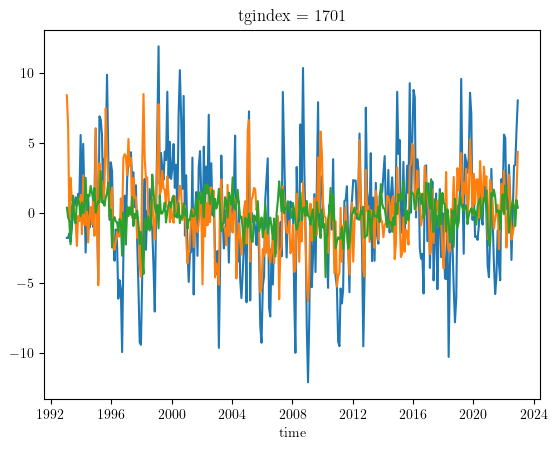

In [21]:
ntg=1
nsim=0
# recs_m1[0][:,4].plot()
# recs_m2[0][:,4].plot()
# recs_m3=recs_m1+recs_m2
real_ts[nsim][:,ntg].plot()
recs_m1[nsim][:,ntg].plot()
# recs_m2[nsim][:,ntg].plot()
recs_m2[nsim][:,ntg].plot()
# recs_tot[nsim][:,ntg].plot()
# (recs_m1[nsim][:,ntg]+recs_m2[nsim][:,ntg]+recs_m3[nsim][:,ntg]).plot()

In [22]:
expvars[0].values

array([0.50212646, 0.21566909, 0.10917858, 0.04631361, 0.0396237 ,
       0.01976455, 0.01267414, 0.01129293, 0.00873961, 0.00791226,
       0.0052353 , 0.00459787, 0.0041559 , 0.00351604, 0.00271477,
       0.00226006, 0.0015741 , 0.00156129])

In [23]:
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!
varscale=300
vmaxin=7

In [24]:
def plot_obs_pcs(tgpcs,vmaxin, varscale):
    fig = plt.figure(figsize=(10,13))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    nsim=0
    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    tot_var=recs_tot[nsim].var(dim='time')    

    ylabspacing = 2
    
    vmin = -12
    vmax2 = -vmin

    # ax1 = plt.subplot2grid((5,3), (1, 1), colspan=2, rowspan=1)
    # # titstr = "Annual mean TG sea level 1950-2022"
    # # ax2 = ax1.twinx()
    # da_tg=xr_tg.TG_IB_CORR+xr_tg.TG_IB_CORR*0
    
    # filled1 = ax1.pcolormesh(
    #     da_tg.time,
    #     np.arange(0, len(tgnames), 1),
    #     da_tg.T,
    #     vmin=vmin,
    #     vmax=vmax2,
    #     cmap=cmap,
    #     shading="nearest",
    # )
    # plt.ylim([0, len(tgnames)])
    
    # ticks = np.arange(0, len(tgnames), ylabspacing)
    # labels = tgnames[np.arange(0, len(tgnames), ylabspacing)]
    # ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    # # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
    # # labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
    # # ax2.yaxis.set_ticks(ticks, labels=labels)

    # plt.figtext(0.02, .9, r"$\bf{" + panellabs[0] + '' "}$", horizontalalignment='left', 
    #                 verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # plt.grid()
    # # ax1.set_title(titstr, loc="center", fontsize=12)
    
    # pos = ax1.get_position()  # get the original position
    
    # cbar_ax = fig.add_axes(
    #     [pos.x1+(pos.x1 - pos.x0) / 40, pos.y0, (pos.x1 - pos.x0) / 40,(pos.y1 - pos.y0)]
    # )
    # cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
    # # cbar.ax.set_title("Detrended/deseasonalized TG sea level", rotation=0, size=10, weight="bold")
    # cbar.ax.tick_params(labelsize=10)

    for nmode in np.arange(3):
        ax = plt.subplot2grid((5,3), (2, nmode), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmin=-vmaxin
        vmax=-vmin

        if nmode<1:    
            VE=recs_m1[nsim].var(dim='time')/tot_var
        else:
            if nmode<2:    
                VE=recs_m2[nsim].var(dim='time')/tot_var
            else:
                VE=recs_m3[nsim].var(dim='time')/tot_var
                
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*VE**1.5,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        for nkey in np.arange(2):
            varval=varscale*(.25+.5*nkey)**1.5
            
            varkey = plt.scatter(
                x=tgs_in.lon,
                y=tgs_in.lat,
                vmin=vmin,
                vmax=vmax,
                c=amps[nsim][nmode,:],
                cmap=cmap,  # this is the changes
                s=varval,
                alpha=1,
                edgecolors=".6",
                linewidth=1,
                # marker=None,
                zorder=7,
                transform=xccrs.PlateCarree(),
            )  ## Important
            
            varkey.set_facecolor("none")   
        
        ax.set_extent([-90, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x0+(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
    import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)    
    for nsp in np.arange(2):
        line = ax.plot(pcs[nsim].time,pcs[nsim][nsp,:],cols[nsp], label = 'data')
    # years = mdates.YearLocator()   # every year
    # years_fmt = mdates.DateFormatter('%Y')
    # ax.xaxis.set_major_locator(years)
    # ax.xaxis.set_major_formatter(years_fmt)
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["TG PC1","TG PC2"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)



/glade/derecho/scratch/clittle/tmp/ipykernel_43751/408418856.py:136: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


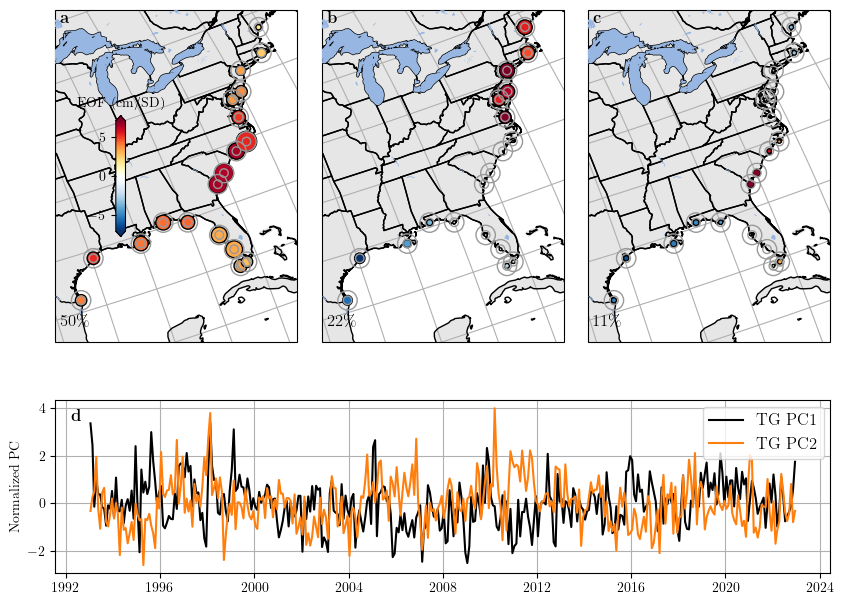

In [25]:
plot_obs_pcs(pcs[0],7, 300)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

In [42]:
def calc_power(pc1):
    import statsmodels.api as sm
    import numpy as np
    import scipy.stats as stats
    
    fs = len(pc1) # Sampling frequency
    t = np.arange(0, len(pc1),1)  # Time vector
    x=np.array(pc1)

    fs=1
    nperseg=64#384/2=192 96
    nfft = nperseg*2
    noverlap = nperseg/2
    
    f, Pxx_den = signal.welch(x,window='hann', fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    
    # Create lagged data
    y = x[1:]
    x = x[:-1]
    
    # Fit a linear regression model
    x = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, x).fit()
    
    # Get the AR(1) coefficient
    ar_coef = model.params[1]
    ar_coef
    Pxx_den = Pxx_den/np.sum(Pxx_den)
    
    T = nfft       #length of time series
    alpha = ar_coef     #red noise lag-one autocorrelation
    beta = np.sqrt(1.-alpha**2)  #beta, red noise parameter
    
    T2 = T/2
    freq = np.arange(0.,T2+1.)/T
    
    rspec = []
    for h in np.arange(0,T2+1,1):
        rspec.append((1.-alpha**2)/(1.-2.*alpha*np.cos(np.pi*(h)/T2)+alpha**2))
        
    for ir in np.arange(0,500):
        
        # construct synthetic time series (note the f for the cosine wave is approximate 0.2)
        x[0] = beta*np.random.randn()
        for j in np.arange(1,T,1):
            x[j] = x[j-1]*alpha + beta*np.random.randn()+np.cos(2.*np.pi*(1.-0.01*np.random.randn())*50./256.*j)
        # print(x)    
        # compute power spectrum
        p = signal.welch(x.T,window='hann', fs=fs, nperseg=nfft, noverlap=noverlap)#, nperseg=T);
        if(ir==0):
            psum = p[1]
        else:
            # add power spectra for each realization together
            psum = psum + p[1]
    
        # calculate average    
    pave = psum/(ir+1.0)
    
    # normalize the spectrum
    pave = pave/np.sum(pave)
    
        # calculate significance using F-test
    dof = 2.*(ir+1.)
    
    # # construct synthetic time series (note the f for the cosine wave is approximate 0.2)
    # x[0] = beta*np.random.randn()
    # for j in np.arange(1,T,1):
    #     x[j] = x[j-1]*alpha + beta*np.random.randn()+0.5*np.cos(2.*np.pi*(0.99*np.random.randn())*50./256.*j)
    
    # # compute power spectrum
    # p = signal.welch(x,window='hann', fs=fs)#, nperseg=nfft, noverlap=noverlap)
    # pave = p[1]
    
    # # normalize the spectrum
    # pave = pave/np.sum(pave)
    
    # # calculate significance using F-test
    # dof = 2
    
    fstat = stats.f.ppf(.95,dof,1000)
    spec99 = [fstat*m for m in rspec]

    return Pxx_den,f,freq,rspec,spec99

/glade/derecho/scratch/clittle/tmp/ipykernel_43751/3730673988.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[2], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_43751/3730673988.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[0], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_43751/3730673988.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[0],'--', label = '99% confidence', ls='--')
/glade/derecho/scratch/clittle/tmp/ipykernel_43751/3730673988.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
/glade/derecho/scratch/clittle/tmp/ipykernel_43751/3730673988.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[1],'--', label = '99% confidence', ls='--')


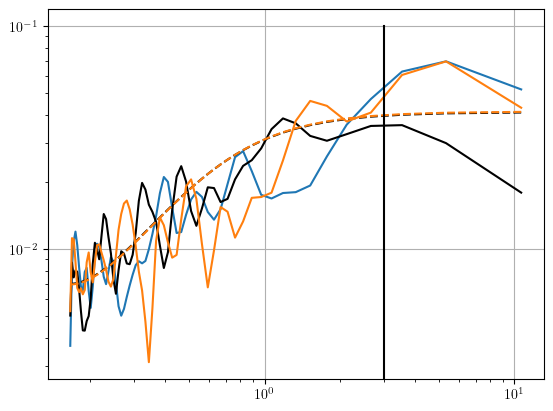

In [43]:
# [Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[0][0,:])
# # plt.plot(np.log10(f),Pxx_den,cols[nsim], label = 'data')
# plt.plot(f*12,(Pxx_den),cols[0], label = 'data')
# # plt.plot(freq*12,spec99/np.sum(rspec),cols[nsim],'--', label = '99% confidence', ls='--')
# [Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[0][1,:])
# # plt.plot(np.log10(f),Pxx_den,cols[nsim], label = 'data')
# plt.plot(f*12,(Pxx_den),cols[1], label = 'data')
# plt.plot(freq*12,spec99/np.sum(rspec),cols[1],'--', label = '99% confidence', ls='--')
[Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[0][2,:])
plt.loglog((1/(12*f)),Pxx_den,cols[2], label = 'data')
# plt.loglog((1/(12*f)),Pxx_den,cols[2], label = 'data')
[Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[0][0,:])
# plt.plot(np.log10(f),Pxx_den,cols[nsim], label = 'data')
plt.loglog((1/(12*f)),Pxx_den,cols[0], label = 'data')
plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[0],'--', label = '99% confidence', ls='--')
# plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
[Pxx_den,f,freq,rspec,spec99]=calc_power(pcs[0][1,:])
# plt.plot(np.log10(f),Pxx_den,cols[nsim], label = 'data')
plt.loglog((1/(12*f)),Pxx_den,cols[1], label = 'data')
plt.loglog((1/(12*f)),spec99/np.sum(rspec),cols[1],'--', label = '99% confidence', ls='--')
# plt.plot(freq*12,spec99/np.sum(rspec),cols[1],'--', label = '99% confidence', ls='--')
plt.grid()
plt.plot([(3),(3)],[0,.1],'k')
# plt.plot([(.05),(.05)],[0,.1],'k')
# plt.plot([(.25),(.25)],[0,.1],'k')

In [110]:
from numpy.fft import rfft, irfft
from ssqueezepy import cwt, icwt, Wavelet, padsignal
from ssqueezepy.visuals import plot, plotscat, imshow
from ssqueezepy.experimental import scale_to_freq
import statsmodels.api as sm

In [111]:
def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]

# Examples.
# print(compute_corr_lag_1(sample_signal(5000, ar_model.params[1])))
# print(np.mean(sample_signal(5000, 0.5, mu=2)))
# print(np.std(sample_signal(5000, 0.5, sigma=3)))# import statsmodels.tsa.ar_model.AutoReg as AutoReg
# train_len = int(0.8*2)
x=pcs[0][0,:].values
train = x
t = np.arange(len(pcs[0].T))

ar_model = sm.tsa.AutoReg(train, lags=1).fit()
print(ar_model.summary())

def calc_ssq_cwt(x, lowper, hiper):

    wavelet = Wavelet(('morlet', {'mu': 6}))  
    wavelet = Wavelet(('gmw'))  
    nv = 32

    n = len(x)
    x_mean = x.mean()

    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)
    freqs = scale_to_freq(scales, wavelet, n, fs=1)
    periods=1/freqs
    power=(np.abs(Wx))**2
    x_inv = icwt(Wx[np.where((periods >= lowper) & (periods <=hiper))], wavelet=wavelet, scales=scales[np.where((periods >= lowper) & (periods <=hiper))], nv=nv, x_mean=x_mean)
    
    return Wx, x_inv, power, periods

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  360
Model:                     AutoReg(1)   Log Likelihood                -319.425
Method:               Conditional MLE   S.D. of innovations              0.589
Date:                Wed, 24 Sep 2025   AIC                            644.851
Time:                        13:12:51   BIC                            656.501
Sample:                             1   HQIC                           649.484
                                  360                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.031      0.135      0.893      -0.057       0.065
y.L1           0.8153      0.031     26.030      0.000       0.754       0.877
                                    Roots           

In [112]:
nsig=1
lowper=10
hiper=30

Wx, x_inv, power, periods = calc_ssq_cwt(x, lowper, hiper)
Wpower = np.nan*power
Wpower = np.tile(Wpower[:, :, None], nsig)

for nsamp in np.arange(nsig):
    xin=sample_signal(len(x), ar_model.params[1],x.mean(),x.std())
    Wx, x_inv, power, periods = calc_ssq_cwt(xin, lowper, hiper) #generate synthetic
    if np.mod(nsamp,100)<1:
        print(nsamp)
    Wpower[:,:,nsamp]=power

0


NameError: name 'calc_ssq_cwt' is not defined

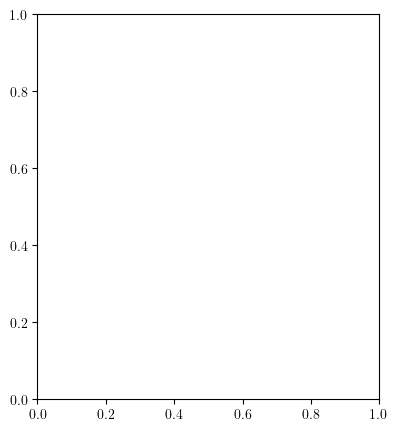

In [41]:
fig=plt.figure(figsize=(15,5))#, tight_layout=True)
levels = np.arange(-6,0,1)
for nsim in np.arange(3):
    ax = plt.subplot2grid((1,3), (0,nsim), colspan=1, rowspan=1)
    # x=x
    # x=tgin.mean(dim='ens').values
    x=pcs[0][nsim,:].values

    Wx, x_inv, power, periods = calc_ssq_cwt(x, lowper, hiper) #generate synthetic
    plt.pcolormesh(t, (periods), np.log2(power), vmin=levels[0], vmax=levels[-1],
                     cmap=plt.cm.plasma)
    # plt.pcolormesh(power.T, vmin=levels[0], vmax=levels[-1],
    #              cmap=plt.cm.plasma)
    plt.ylim(2,72)

# peridx=find_nearest(periods, 12)
# ax.plot([t.min(), t.max()],np.log2([periods[peridx], periods[peridx]]),'k')
# peridx=find_nearest(periods, 24)
# ax.plot([t.min(), t.max()],np.log2([periods[peridx], periods[peridx]]),'k')
    # sig1=np.percentile(Wpower,95,axis=2)
    # plt.contour(t, (periods), power>sig1, [-99, 0], colors='k', linewidths=2)
# ax = plt.subplot2grid((1,3), (0, 1), colspan=1, rowspan=1)
# plt.pcolormesh(t, np.log2(periods), Wpower.mean(axis=2), vmin=levels[0], vmax=levels[-1],
#                  cmap=plt.cm.plasma)
# ax = plt.subplot2grid((1,3), (0, 2), colspan=1, rowspan=1)
    # plt.pcolormesh(t, (periods), np.percentile(Wpower,95,axis=2), vmin=levels[0], vmax=levels[-1],
    #                  cmap=plt.cm.plasma)

In [28]:
import sys
sys.path.append("./../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/lfca/Python")
import scipy as sp
from scipy import io
from signal_processing import lfca

In [34]:
cutoff = 25
truncation = 10
# cutoff = 20
# truncation = 35

In [35]:
da=xr_tg.TG_IB_CORR
da.values.shape

(360, 19)

In [36]:
def tg_lfca(da, cutoff, truncation):
    lat_axis = da.tgindex.values
    time = da.time.values
    sst = da.to_numpy().squeeze()
    nlat = da.shape[1]
    ntime = da.shape[0]
    x = da.values
    area_weights = da[0, :] * 0 + 1
    area_weights = np.expand_dims(area_weights, axis=0)
    area_weights
    normvec = np.transpose(area_weights) / np.sum(area_weights)
    scale = np.sqrt(normvec)
    (
        lfcs,
        lfps,
        weights,
        r,
        pvar,
        pcs,
        eofs,
        ntr,
        pvar_slow,
        pvar_lfc,
        r_eofs,
        pvar_slow_eofs,
        lf_ts,
    ) = lfca(x, cutoff, truncation, scale)

    return lfcs, lfps, pcs, eofs, pvar_slow, pvar_lfc, lf_ts

In [37]:
tglfcs1950_gmrem, tglfps1950_gmrem, tgpcs1950_gmrem, tgeofs1950_gmrem, tgflf1950_gmrem, tgftot1950_gmrem, lf_ts_gmrem = tg_lfca(
    da, cutoff, truncation
)
# #GMout
# tglfcs1950_gmrem[:,0:2] = 0 - tglfcs1950_gmrem[:,0:2]
# tglfps1950_gmrem[0:2,:] = 0 - tglfps1950_gmrem[0:2,:]

array([29.88296196,  5.9120008 , 19.22833873,  2.73975398, 17.49257018,
        7.10047827,  3.1522145 ,  7.50048229,  3.91122056,  0.54226409])

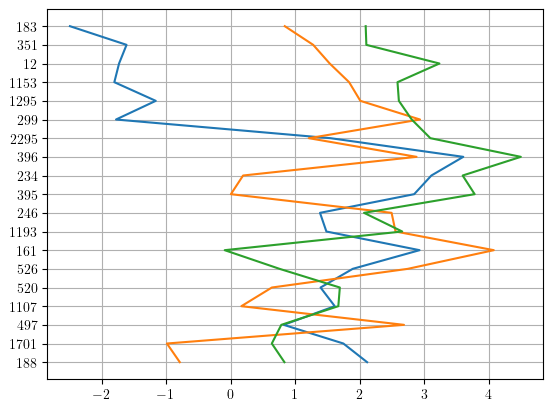

In [40]:
plt.plot(tglfps1950_gmrem[0],da.tgindex)
plt.plot(tglfps1950_gmrem[2],da.tgindex)
plt.plot(tglfps1950_gmrem[4],da.tgindex)
plt.grid()
tgflf1950_gmrem

In [ ]:
plt.plot(da.time,tglfcs1950_gmrem[:,0]+4)
plt.plot(da.time,tglfcs1950_gmrem[:,1])
plt.plot(da.time,tglfcs1950_gmrem[:,2]-4)
# plt.plot(da.time,tglfcs1950_gmrem[:,1])
# plt.plot(da.time,tglfcs1950_gmrem[:,2])

In [65]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)

def filtfilt_bpbutter_2d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_2d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    
    
def filtfilt_bpbutter_3d_band(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_band,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

def filtfilt_bpbutter_3d_high(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_high,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["nlat","nlon","time"], [], [], [], []],  # regrid
        output_core_dims=[["nlat","nlon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt
def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["lat","lon","time"], [], [], [], []],  # regrid
        output_core_dims=[["lat","lon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [66]:
cutoff=13 #months
fs=1
order=5
dain=filtfilt_bpbutter_2d_low(xr_tg.TG_IB_CORR,1/cutoff,0*1/3,fs,order,dim='time')
dain=dain.transpose('time', 'tgindex').load()
edgevals=int(np.ceil(cutoff/2))# dain=resid
dain=dain.isel(time=slice(edgevals,-edgevals))
resid=xr_tg.TG_IB_CORR.isel(time=slice(edgevals,-edgevals))-dain

In [67]:
# dain=resid

In [68]:
kwargs = dict(n_modes=len(xr_tg.TG_IB_CORR.T)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(1):

    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [69]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

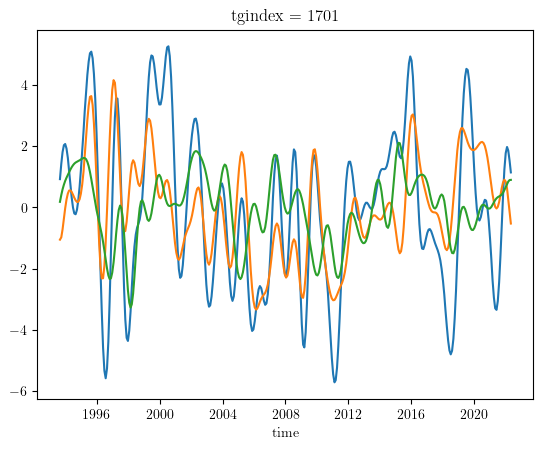

In [70]:
ntg=1
nsim=0
# recs_m1[0][:,4].plot()
# recs_m2[0][:,4].plot()
# recs_m3=recs_m1+recs_m2
real_ts[nsim][:,ntg].plot()
recs_m1[nsim][:,ntg].plot()
# recs_m2[nsim][:,ntg].plot()
recs_m2[nsim][:,ntg].plot()
# recs_tot[nsim][:,ntg].plot()
# (recs_m1[nsim][:,ntg]+recs_m2[nsim][:,ntg]+recs_m3[nsim][:,ntg]).plot()

In [71]:
expvars[0].values

array([0.49201916, 0.25316413, 0.10281938, 0.04613848, 0.03322908,
       0.01408884, 0.01312539, 0.01199894, 0.00764124, 0.00683282,
       0.00394669, 0.00361773, 0.00340505, 0.00249285, 0.00172415,
       0.00140262, 0.00117228, 0.00079363])

In [72]:
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!
varscale=300
vmaxin=7

/glade/derecho/scratch/clittle/tmp/ipykernel_18034/408418856.py:136: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


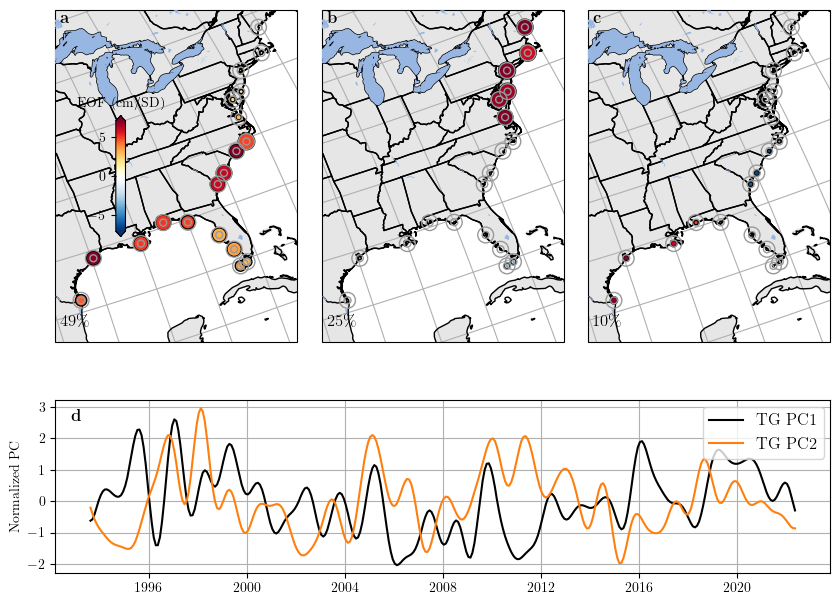

In [73]:
plot_obs_pcs(pcs[0],7, 200)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

In [64]:
##residuals

/glade/derecho/scratch/clittle/tmp/ipykernel_18056/4229218213.py:136: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


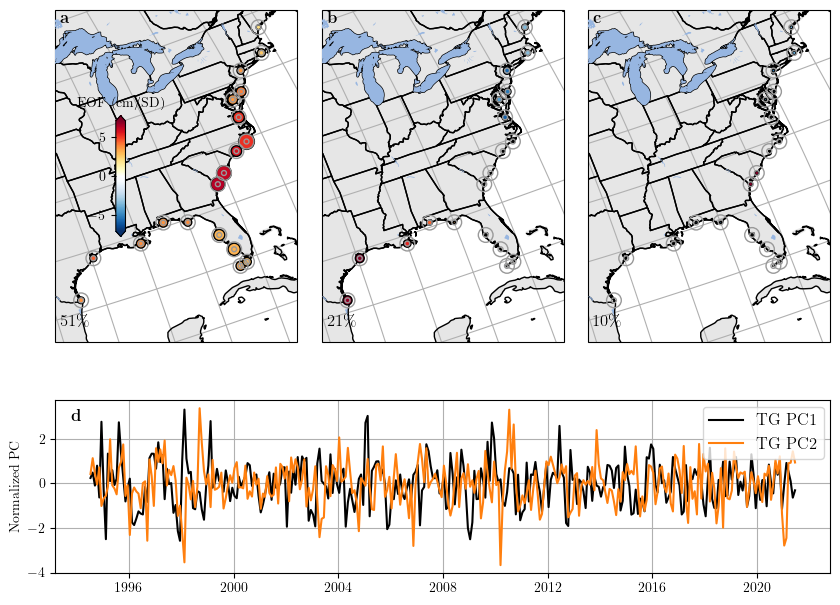

In [170]:
plot_obs_pcs(pcs[0],7, 200)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

## Altimetry input

In [65]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly*.nc')
alt=alt*100

In [66]:
alt=alt.rename({'Time': 'time','Longitude':'lon','Lon_bounds':'lon_b','Latitude':'lat','Lat_bounds':'lat_b'})
alt = alt.drop(['lon_b','lat_b'])
ds_alt=alt.sel(time=slice('1992-01-01', '2023-01-01'))

/glade/derecho/scratch/clittle/tmp/ipykernel_18556/2505444263.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  alt = alt.drop(['lon_b','lat_b'])


In [67]:
gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/gmsl_mo.nc")
gmsl=gmsl.sel(time=slice('1992-01-01', '2023-01-01'))#,Longitude=slice(xlo,xhi),Latitude=slice(ylo,yhi))
# gmsl_df=gmsl.to_pandas()/10
gmsl=gmsl.gmsl_variation/10

In [68]:
# xlo=1550; xhi=2200; ylo=550; yhi=900;
xlo=1550; xhi=1800; ylo=600; yhi=800;
da=ds_alt.SLA-gmsl
da=da.isel(lon=slice(xlo,xhi),lat=slice(ylo,yhi))#.sel(time=slice('1993-01-01','2019-1-1'))
da=da.isel(time=slice(edgevals,-edgevals))

In [69]:
da['time']=pcs[0].time

In [70]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason_tg(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear_tg(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea  
    return fosi_desea.drop_vars('month'), fosi_trend
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [71]:
[da, datrend]=detrend_deseason(da)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/xarray/core/indexing.py:1679: PerformanceWarning: Slicing with an out-of-order index is generating 27 times more chunks
  return self.array[key]


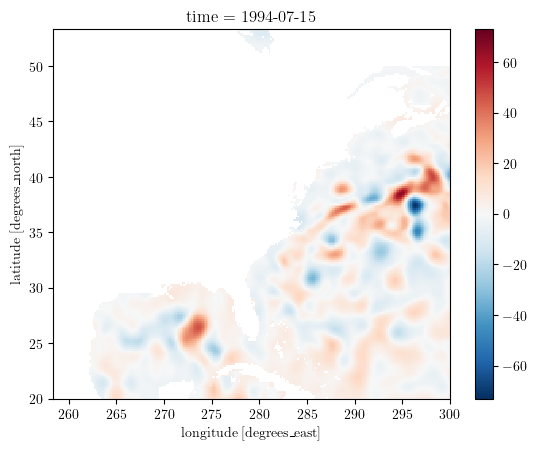

In [72]:
da[0,:,:].plot()

In [73]:
pvalc=.05
ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")
# ds_bathy.depth

## Monthly regressions on altimetry

In [74]:
def plot_ssh_reg(tgpcs,SSH,tglons,tglats):
    fig = plt.figure(figsize=(18,12), tight_layout=True)
    vmin=-6
    vmax=-vmin
    
    cmap = mycolors.blue2red_cmap(20)
    
    for nsp in np.arange(2):
        for nsim in np.arange(1):
            lagx=0
            lons=tglons
            lats=tglats 
            tgpcs=tgpcs
            regressand=SSH 
            # regressand2=xr_tg.TG_IB_CORR
                    
            focusts=regressand[:,0,0].fillna(0)*0+np.real(tgpcs[nsp,:])
            cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand, lagx=lagx)
            altrc=slope+regressand[0,:,:]*0
            altpval=pval
            mask=1+0/(pval<pvalc)
            # focusts=regressand2.isel(tgindex=0).squeeze()*0+np.real(tgpcs[nsp,:])
            # cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand2, lagx=lagx)
            
            ax = plt.subplot2grid((1,2), (0, nsp), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")
            
            pos = ax.get_position() # get the original position 
            ax.set_extent([-100, -60, 20, 52], crs=xccrs.PlateCarree())
            # ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
            im = ax.pcolormesh(lons, lats, mask*altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            # im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
                        cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    

            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                            np.arange(100,101,1),colors='.6',linewidths=2,zorder=2,transform=xccrs.PlateCarree())
            
            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                           np.arange(1000,2000,1000),colors='.6',linewidths=1,zorder=2,transform=xccrs.PlateCarree())
            

            # cov, cor, slopeu, intercept, pvalu, stderr = lag_linregress_3D(
            #     x=focusts, y=regressand3, lagx=0
            # )
            # masku = pvalu > pvalc
            
            # cov, cor, slopev, intercept, pvalv, stderr = lag_linregress_3D(
            #     x=focusts, y=regressand4, lagx=0
            # )
            # maskv = pvalv > pvalc
            # maskin=(masku+maskv)>0 #either masked
            # maskin=(1*masku+1*maskv)>1 #both masked
            # maskin=1+0/(~maskin)
            # # maskin=1+0/(~maskin*0+1)
            
            # # llon,llat=np.meshgrid(regressand3.lon,regressand3.lat)
            # q=ax.quiver(lrtauy.TLONG.values, lrtauy.TLAT.values, slopeu, slopev, transform=xccrs.PlateCarree(),angles='xy',scale_units='xy', width=2e-3, scale=2e-2,color='.6')#, regrid_shape=20)#tx: 3e-1)
            # q=ax.quiver(lrtauy.TLONG.values, lrtauy.TLAT.values, maskin*slopeu, maskin*slopev, transform=xccrs.PlateCarree(),angles='xy',scale_units='xy', width=2e-3, scale=2e-2)#, regrid_shape=20)#tx: 3e-1)
            
            if nsp==0:
                cbar_ax = fig.add_axes(
                    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
                )
                cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
                # cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
                cbar.ax.tick_params(labelsize=10)
                
            # if nsim<1:
            #     plt.figtext(.05, .95, 'Regression on HR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
            # else:
            #     plt.figtext(.05, .95, 'Regression on LR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
                            
            ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
            # ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
    
            ax.coastlines(zorder=5)
            ax.gridlines()
            # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
    # return altrc

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


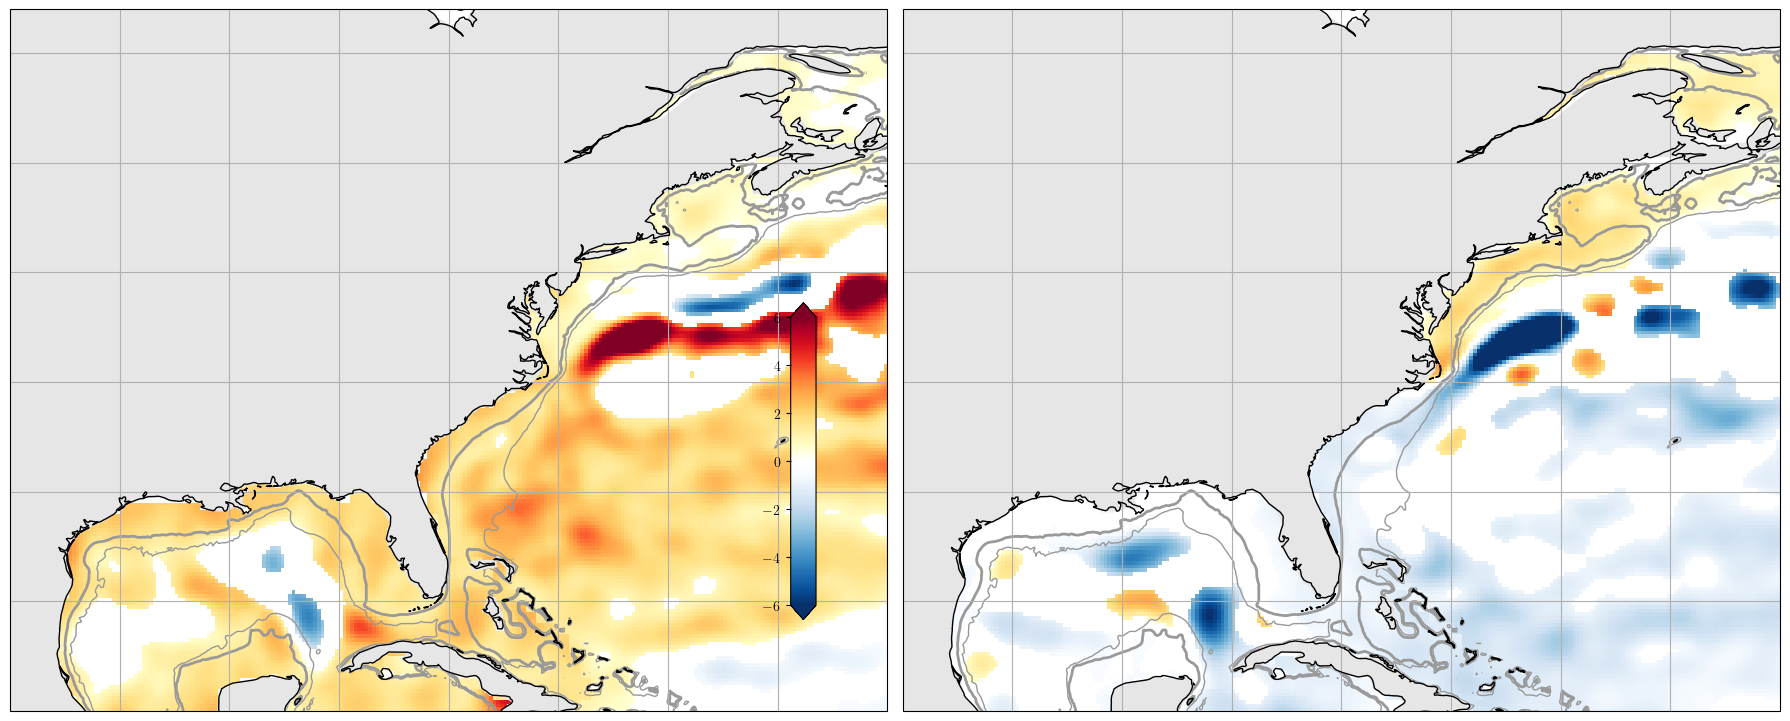

In [75]:
inc=1
plot_ssh_reg(pcs[0],da,da.lon,da.lat)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


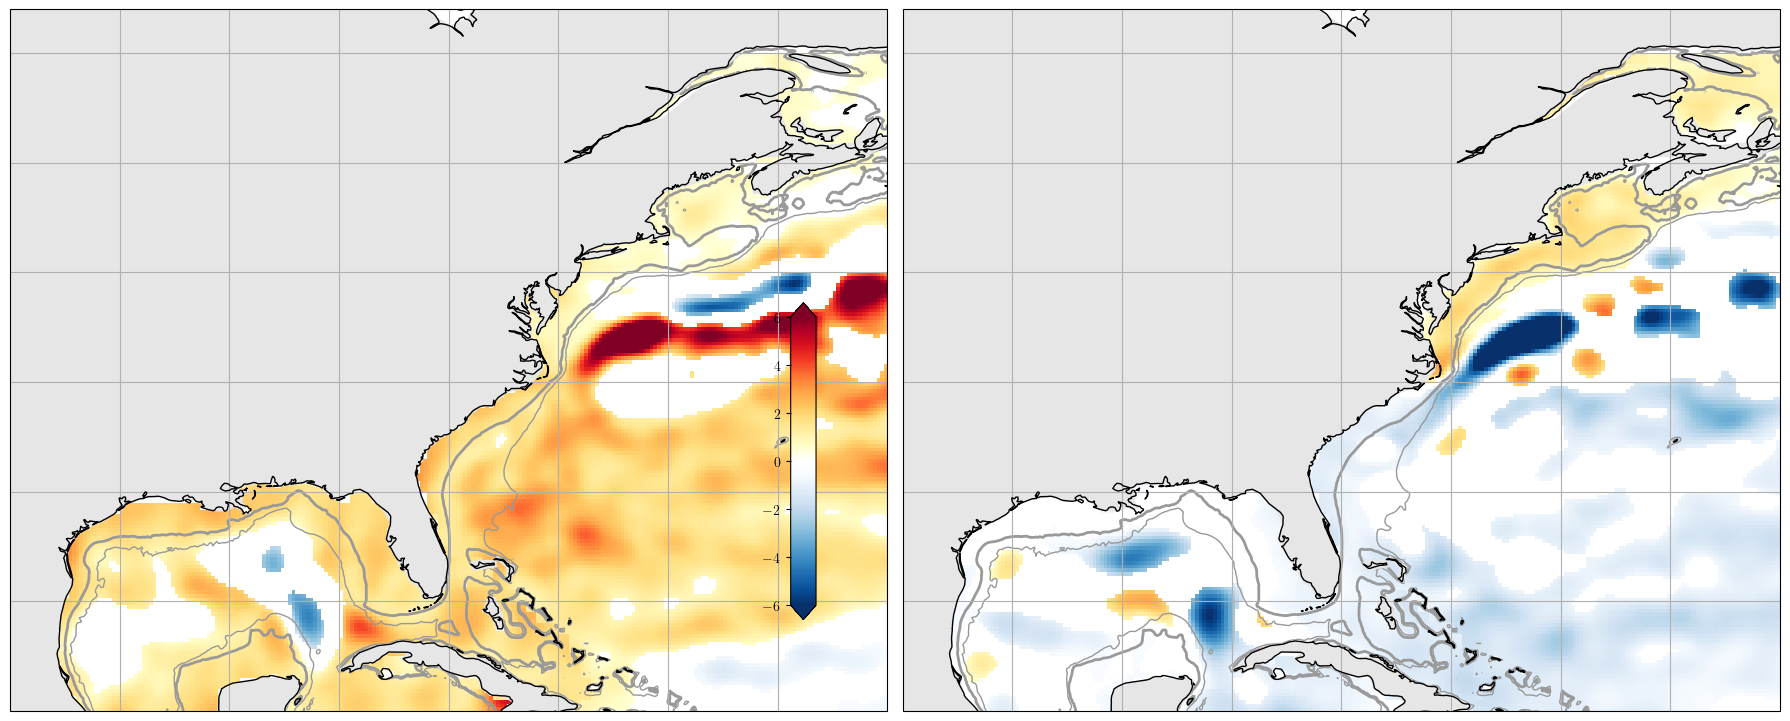

In [76]:
inc=1
plot_ssh_reg(pcs[0],da,da.lon,da.lat)